In [20]:
%%time
import numpy as np
import matplotlib.pyplot as plt
import sys

for mod in ["sutton_functions"]:
    if mod in sys.modules:
            del sys.modules[mod]
            
from sutton_functions import *

CPU times: user 4.39 ms, sys: 6 ms, total: 10.4 ms
Wall time: 12.6 ms


<timed exec>:9: DeprecationWarning: sutton_functions.py is deprecated; import from the 'sutton' package (src/sutton) instead.


In [21]:
# Example usage
temperature_C = 20 # Temperature in Celsius
temperature_K = temperature_C + 273.15  # Convert to Kelvin

es = saturation_vapor_pressure(temperature_K)
rho = vapor_concentration(es, temperature_K)

print(f"Saturation vapor pressure at {temperature_C}°C is {es:.2f} Pa")
print(f"Water vapor concentration at {temperature_C}°C is {rho:.2f} g/m³")


Saturation vapor pressure at 20°C is 2366.09 Pa
Water vapor concentration at 20°C is 17.49 g/m³


In [22]:
def integrate_T_implicit(n, m, dx, dz, A, B, C, Tup, Ts, Ta):
    """
    This function computes the coefficients
      of the second-order system of variable s(t+dt)
      formed by the (known) profile values at s(t).
      
      The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
      The coefficients in AA4 are used from s(t)
      The coefficients in AA1 are mainly the diffusion
      The coefficients in AA2 include advection
      The coefficients in AA3 include advection + s(t+dt)  
    """
    # Setup the tridiagonal solver for mean H2O concentration
    AA1 = - A * B
    AA2 = - C * B
    AA3 = 1 / dx
    AA4 = Tup / dx
    
    upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
    dia = (-2 * AA1 / (dz ** 2) + AA3)
    lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
    co = np.zeros(m)
    co[:] = AA4

    # Ensure the boundary conditions are state, not flux
    lod[0] = 0
    lod[m-1] = 0
    dia[0] = 1
    dia[m-1] = 1
    upd[0] = 0
    upd[m-1] = 0

    # Enforce surface and upper H2O concentration
    co[0] = Ts
    co[-1] = Ta

    # Call the tridiagonal solver
    T1 = thomas(lod, dia, upd, co)
    dTdz = our_central_difference(T1, dz)
    
    # FT = - A * dTdz
    
    FT = np.zeros_like(T1)
    FT[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5
    
    FT[1] = FT[2]
    FT[0] = FT[1]
    
    
    return T1, FT


def integrate_H2O_implicit(n, m, dx, dz, A, B, C, Qup, Qs, Qa):
    """
    This function computes the coefficients
      of the second-order system of variable s(t+dt)
      formed by the (known) profile values at s(t).
      
      The system is AA1 d2s/dz2 + AA2 ds/dz + AA3 s=AA4
      The coefficients in AA4 are used from s(t)
      The coefficients in AA1 are mainly the diffusion
      The coefficients in AA2 include advection
      The coefficients in AA3 include advection + s(t+dt)  
    """
    # Setup the tridiagonal solver for mean H2O concentration
    AA1 = - A * B
    AA2 = - C * B
    AA3 = 1 / dx
    AA4 = Qup / dx
    
    upd = (AA1 / (dz ** 2) + AA2 / (2 * dz))
    dia = (-2 * AA1 / (dz ** 2) + AA3)
    lod = (AA1 / (dz ** 2) - AA2 / (2 * dz))
    
    co = np.zeros(m)
    co[:] = AA4

    # Ensure the boundary conditions are state, not flux
    lod[0] = 0
    lod[m-1] = 0
    dia[0] = 1
    dia[m-1] = 1
    upd[0] = 0
    upd[m-1] = 0

    # Enforce surface and upper H2O concentration
    co[0] = Qs
    co[m-1] = Qa

    # Call the tridiagonal solver
    Q1 = thomas(lod, dia, upd, co)
    dQdz = our_central_difference(Q1, dz)

    # Fq = - A * dQdz
    Fq = np.zeros_like(Q1)    
    Fq[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

    Fq[1] = Fq[2]
    Fq[0] = Fq[1]    
    
    return Q1, Fq

### Boundary conditions

In [23]:
# Water vapor script
k = 0.4  # von Karman constant
g = 9.8 

# Flow conditions
ustar = 0.2      # Friction velocity (m/s)
zom = 0.1/100    # Momentum roughness length (m)
zoh =  zom*7.4*np.exp(-2.4*(ustar*zom/1.5e-5)**0.25)
# R = ustar*zom/1.5e-5

# Domain specification
Lx = 2000
Hmax = 50

Lx=2000 
Hmax=50

xmin = 0
xmax = Lx
zmin = zom
zmax = Hmax

# Generate grid
nx = 1000
nz = 200
dx = (xmax - xmin) / nx
dz = (zmax - zmin) / nz

z = np.arange(zmin, zmax, dz)

zc = z.copy()
zc[0] = dz / np.log(z[1]/z[0])
for i in range(1, nz-1):
    zc[i] = dz*2/ np.log(z[i+1]/z[i-1])
zc[-1] = dz / np.log(z[-1]/z[-2])

    
x = np.arange(xmin, xmax + dx, dx)

# Generate the mean velocity from log-law
U = (ustar / k) * np.log(z / zom)

# Specify upwind temperature (as background), used to specify
# downwind surfce humidity
Ta_u = 25
Ts_u = 30
wT = - (Ta_u - Ts_u)*k*ustar/np.log(zmax/zom)
Tup = Ts_u - wT/(k*ustar)*np.log(z/zom)
Ts_d = 20
Ta_d = Ta_u

es = saturation_vapor_pressure(Ts_u + 273.15)
rho = vapor_concentration(es, Ts_u + 273.15)

# Water vapor boundary conditions (gm/m3)
Qs = rho      # Surface wv concentration
Qa = 25       # Upwind background atmospheric wv concentration
Qs_u = Qa
print("Water vapor boundary conditions = {0:.2f} (gm/m3) ".format( Qs))

Water vapor boundary conditions = 31.12 (gm/m3) 


## Solve water vapor

In [24]:
# Specify upwind wv concentration (as background)
Qup = np.ones(nz) * Qa

# Setup coefficients for implicit scheme
A = k * z * ustar
B = 1.0 / (U+ 1e-10)
C = our_central_difference(A, dz)

# Upwind wv concentrations and fluxes
Q1 = Qup
Q = np.zeros((nx + 1, nz))
Q[0, :] = Q1
FluxQ = np.zeros((nx + 1, nz))

dQdz = our_central_difference(Q1, dz)

Fq = np.zeros_like(Q1)
Fq[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dQdz[:-1] + dQdz[1:]) * 0.5

Fq[1] = Fq[2]
Fq[0] = Fq[1]


FluxQ[0, :] =  zc/z*Fq

# Begin downwind calculations by marching along x
for i in range(nx):
    integrate_H2O_implicit
    Q2, Fq = integrate_H2O_implicit(nx, nz, dx, dz, A, B, C, Q1, Qs, Qa)
    Q[i+1, :] = Q2
    FluxQ[i+1, :] = Fq
    Q1 = Q2

FluxQ[FluxQ < 1e-10] = 0    


### Temperature

In [25]:
# # Compute local Obukov length
# Lo = - ustar**3/(k*g*FluxT[10, 0]/(273.15+Ts_d))
# xi = z/Lo
# print (Lo)

# plt.plot(Tup, z)
# plt.xlabel("upwind $T$ (C)")
# plt.ylabel(" $z$ (m)")

In [26]:
# Setup coefficients for implicit scheme
A = k * z * ustar
B = 1.0 / (U + 1e-10)
C = our_central_difference(A, dz)

# Upwind wv concentrations and fluxes
T1 = Tup
T = np.zeros((nx + 1, nz))
T[0, :] = T1
FluxT = np.zeros((nx + 1, nz))

dTdz = our_central_difference(T1, dz)
# FT = - A * dTdz

FT = np.zeros_like(T1)

FT[1:] = - 0.5 * (A[1:] + A[:-1]) * (0*dTdz[:-1] + dTdz[1:]) * 0.5

FT[1] = FT[2]
FT[0] = FT[1]
FluxT[0, :]   = FT # zc/z

# Begin downwind calculations by marching along x
for i in range(nx):
    T2, FT = integrate_T_implicit(nx, nz, dx, dz, A, B, C, T1, Ts_d, Ta_d)
    T[i + 1, :] = T2
    FluxT[i + 1, :] = FT
    T1 = T2

(0.0, 0.2)

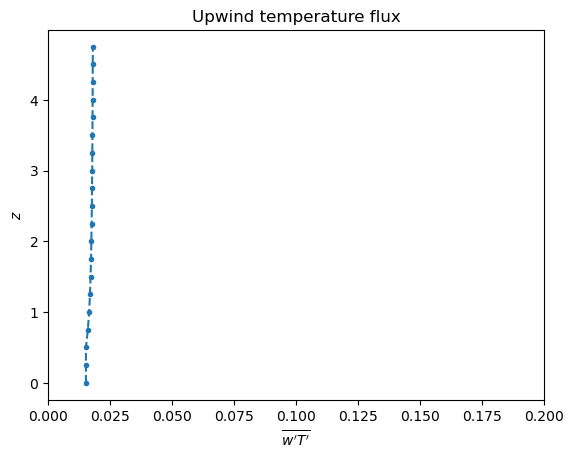

In [27]:
plt.plot(FluxT[0, :20], z[:20], '.--')
plt.xlabel("$\overline{w'T'}$")
plt.ylabel("$z$")
plt.title("Upwind temperature flux")
plt.xlim(0, 0.2)

Text(0.5, 1.0, 'Surface sensible and latent heat flux (W/m$^2$)')

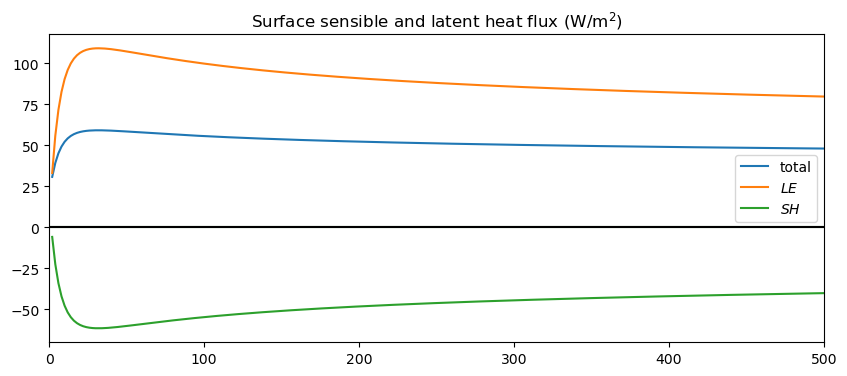

In [28]:
plt.figure(figsize = (10,4))
ax = plt.gca()
level = 0
FluxTotal = FluxT*1005*1.2 + FluxQ*2.5*1e6/1000
ax.plot(x[1:], FluxTotal[1:, level], label = 'total')
ax.plot(x[1:], FluxQ[1:, level]*2.260*1e6/1000, label = "$LE$")
ax.plot(x[1:], FluxT[1:, level]*1005*1.2, label = "$SH$")
ax.axhline(FluxT[-1, level], c = 'C2')
ax.legend()
ax.axhline(0, c= 'k')
ax.set_xlim(0, 500)
ax.set_title("Surface sensible and latent heat flux (W/m$^2$)")

    Upwind 
    SH = Rn
    LH = 0



In [29]:
xx, TT = padit(x, nz, Tup, T)
xx, QQ = padit(x, nz, Qup, Q)

xx, FluxQQ = padit(x, nz, FluxQ[0, :], FluxQ)
xx, FluxTT = padit(x, nz, FluxT[0, :], FluxT)


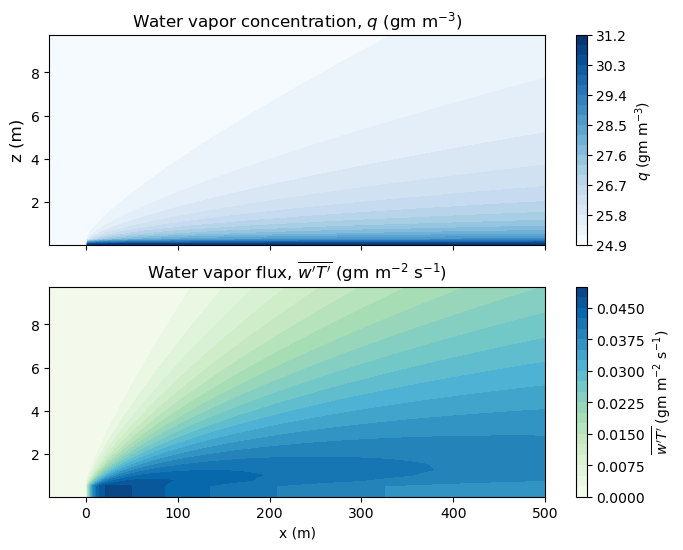

In [30]:
fig, axes = plt.subplots(2, 1, figsize = (8, 6), sharex = True)

xind = np.where(xx > 500)[0][0]
zind = np.where(z > 10)[0][0]
fontsize = 12

ax = axes[0]
g = axes[0].contourf(xx[:xind], z[:zind], QQ[:xind, :zind].T, 20, vmin = Ta_u, cmap = "Blues")
ax.set_ylabel("z (m)", fontsize = fontsize)
plt.colorbar(g, label="$q$ (gm m$^{-3}$)")
ax.set_title("Water vapor concentration, $q$ (gm m$^{-3}$)", fontsize=fontsize)

ax = axes[1]
g = axes[1].contourf(xx[:xind], z[:zind], FluxQQ[:xind, :zind].T, 20,  cmap = "GnBu")
ax.set_xlabel("x (m)")

ax.set_title("Water vapor flux, $\overline{w'T'}$ (gm m$^{-2}$ s$^{-1}$)", fontsize=fontsize)

plt.colorbar(g, label="$\overline{w'T'}$ (gm m$^{-2}$ s$^{-1}$)")

Text(0.5, 1.0, "$\\overline{w'q'} \\ $  ")

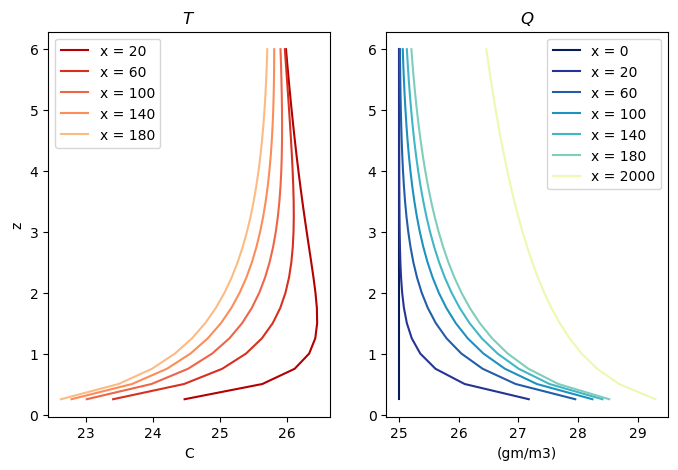

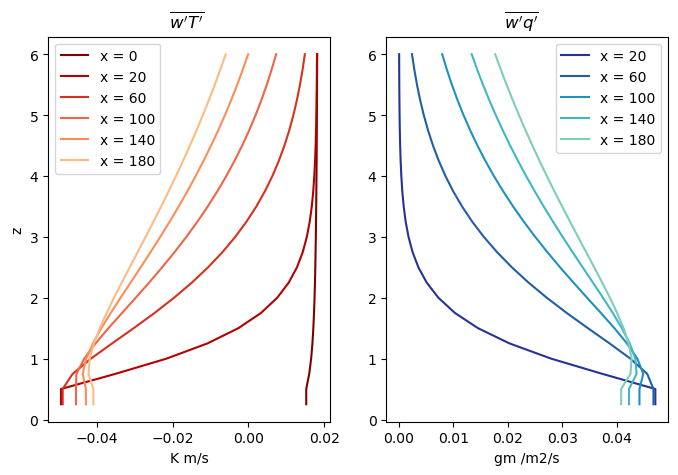

In [31]:
reds = ['#fff7ec','#fee8c8','#fdd49e','#fdbb84','#fc8d59','#ef6548','#d7301f','#b30000','#7f0000']
blues = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#253494','#081d58']

zind = 25
xinds = np.arange(10, 100, 20)

fig, axes = plt.subplots(1,2, figsize = (8, 5))
ax = axes[0]
for ind, i in enumerate(xinds):
    ax.plot( T[i, 1:zind], z[1:zind], label = "x = {0:.0f}".format(x[i]), c = reds[-ind-2])
ax.legend()
ax.set_xlabel("C")
ax.set_ylabel("z")
ax.set_title("$T$")
ax = axes[1]

ax.plot( Q[0, 1:zind], z[1:zind], c = blues[-1], label = 'x = 0')
for ind, i in enumerate(xinds):
    ax.plot( Q[i, 1:zind], z[1:zind], label = "x = {0:.0f}".format(x[i]), c = blues[-ind-2])
ax.plot( Q[-1, 1:zind], z[1:zind], label = "x = {0:.0f}".format(x[-1]), c = blues[1])    
ax.legend()
ax.set_xlabel("(gm/m3)")
ax.set_title("$Q$ ")

fig, axes = plt.subplots(1,2, figsize = (8, 5))
ax = axes[0]
ax.plot( FluxT[0][1:zind], z[1:zind], c = reds[-1], label = 'x = 0')
for ind, i in enumerate(xinds):
    ax.plot( FluxT[i][1:zind], z[1:zind], label = "x = {0:.0f}".format(x[i]), c = reds[-ind-2])
ax.legend()

ax.set_xlabel("K m/s")
ax.set_ylabel("z")
ax.set_title("$\overline{w'T'} \ $ ")

ax = axes[1]
for ind, i in enumerate(xinds):
    ax.plot( FluxQ[i][1:zind], z[1:zind], label = "x = {0:.0f}".format(x[i]), c = blues[-ind-2])

ax.legend()
ax.set_xlabel("gm /m2/s")
ax.set_title("$\overline{w'q'} \ $  ")

Text(0.5, 1.0, "$\\overline{w'q'}$")

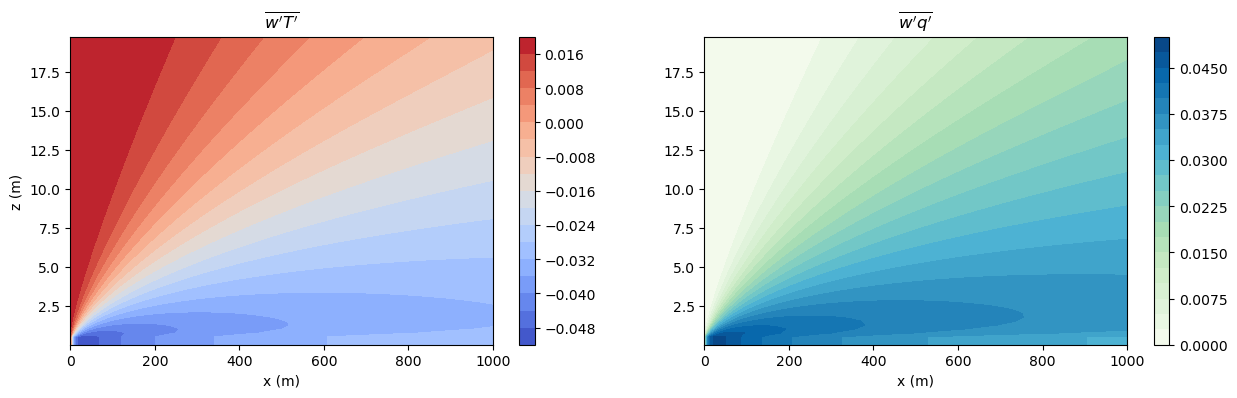

In [32]:
fig, axes = plt.subplots(1,2, figsize = (15, 4))

xind = np.where(x > 1000)[0][0]
zind = np.where(z > 20)[0][0]

ax = axes[0]
g = axes[0].contourf(x[:xind], z[:zind], FluxT[:xind, :zind].T, 20,cmap = "coolwarm")
ax.set_xlabel("x (m)")
ax.set_ylabel("z (m)")
plt.colorbar(g)

ax.set_title("$\overline{w'T'}$")

ax = axes[1]
g = axes[1].contourf(x[:xind], z[:zind], FluxQ[:xind, :zind].T, 20,  cmap = "GnBu")
ax.set_xlabel("x (m)")
plt.colorbar(g)
ax.set_title("$\overline{w'q'}$")


Text(0.5, 1.0, 'z < 20 m')

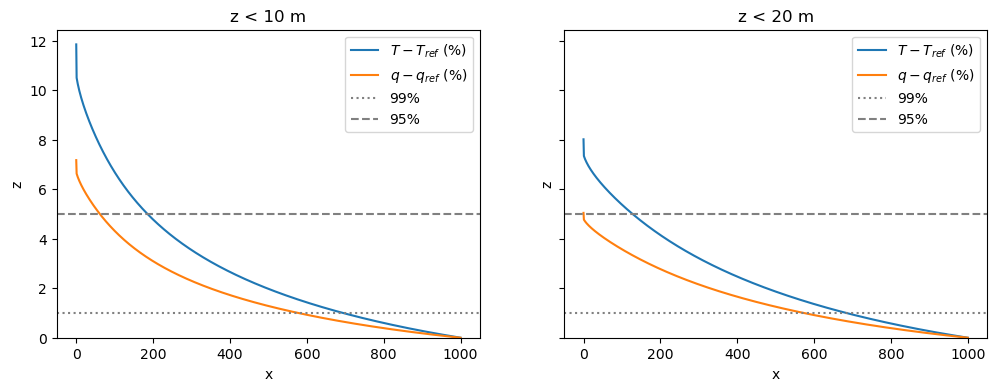

In [33]:
fig, axes = plt.subplots(1,2, sharey = True, figsize = (12, 4))
ax = axes[0]

ind = np.where(z> 10)[0][0]
ref = T[-1][:ind]
ax.plot(( ((T[:, :ind] - ref)/ref).T).mean(0)*100, label = "$T - T_{ref}$ (%)")
ref = Q[-1][:ind]
ax.plot(  ( ( (- Q[:, :ind] + ref)/ref).T).mean(0)*100, label = "$q - q_{ref}$ (%)")
ax.axhline(1, ls = ":", c = 'grey', label = "99%")
ax.axhline(5, ls = "--", c = 'grey', label = "95%")
ax.set_ylim(0) 
ax.legend()
ax.set_ylabel("z")
ax.set_xlabel("x")
ax.set_title("z < 10 m" )

ax = axes[1]
ind = np.where(z> 20)[0][0]
ref = T[-1][:ind]
ax.plot(( ((T[:, :ind] - ref)/ref).T).mean(0)*100, label = "$T - T_{ref}$ (%)")
ref = Q[-1][:ind]
ax.plot(  ( ( (- Q[:, :ind] + ref)/ref).T).mean(0)*100, label = "$q - q_{ref}$ (%)")
ax.axhline(1, ls = ":", c = 'grey', label = "99%")
ax.axhline(5, ls = "--", c = 'grey', label = "95%")
ax.set_ylim(0)
ax.legend()
ax.set_ylabel("z")
ax.set_xlabel("x")
ax.set_title("z < 20 m" )

Text(0.5, 1.0, 'z < 20 m')

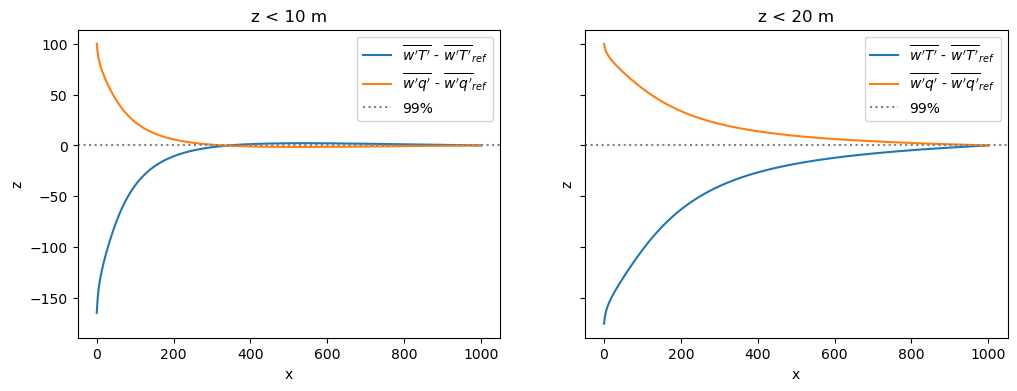

In [34]:
fig, axes = plt.subplots(1,2, sharey = True, figsize = (12, 4))
ax = axes[0]

ind = np.where(z> 10)[0][0]
ref = FluxT[-1][:ind]
ax.plot(( ((FluxT[:, :ind] - ref)/ref).T).mean(0)*100, label = "$\overline{w'T'}$ - $\overline{w'T'}_{ref}$ ")
ref = FluxQ[-1][:ind]
ax.plot(  ( ( (- FluxQ[:, :ind] + ref)/ref).T).mean(0)*100, label = "$\overline{w'q'}$ - $\overline{w'q'}_{ref}$ ")
ax.axhline(0, ls = ":", c = 'grey', label = "99%")
# ax.set_ylim(0) 
ax.legend()
ax.set_ylabel("z")
ax.set_xlabel("x")
ax.set_title("z < 10 m" )

ax = axes[1]
ind = np.where(z> 20)[0][0]
ref = FluxT[-1][:ind]
ax.plot(( ((FluxT[:, :ind] - ref)/ref).T).mean(0)*100, label = "$\overline{w'T'}$ - $\overline{w'T'}_{ref}$ ")
ref = FluxQ[-1][:ind]
ax.plot(  ( ( (- FluxQ[:, :ind] + ref)/ref).T).mean(0)*100, label = "$\overline{w'q'}$ - $\overline{w'q'}_{ref}$ ")
ax.axhline(0, ls = ":", c = 'grey', label = "99%")
# ax.set_ylim(0)
ax.legend()
ax.set_ylabel("z")
ax.set_xlabel("x")
ax.set_title("z < 20 m" )


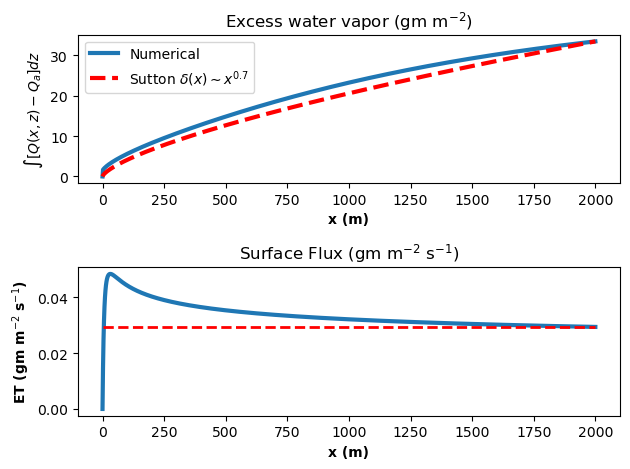

In [35]:

# Plot excess water vapor and surface flux
plt.figure(2)
plt.clf()
QQ = np.sum(Q - Qa, axis=1) * dz

plt.subplot(2, 1, 1)
plt.plot(x, QQ, '-', linewidth=3)
plt.plot(x, np.max(QQ) * (x / Lx) ** 0.7, 'r--', linewidth=3)
plt.xlabel('x (m)', fontsize=10, fontweight='bold')
plt.ylabel(r'$\int [Q(x,z) - Q_a]dz$', fontsize=10, fontweight='bold')
plt.title('Excess water vapor (gm m$^{-2}$)', fontsize=12)
plt.legend(['Numerical', 'Sutton $\delta(x) \sim x^{0.7}$'], loc='upper left')

plt.subplot(2, 1, 2)
plt.plot(x, FluxQ[:, 0], '-', linewidth=3)
plt.plot(x, np.ones(nx + 1) * FluxQ[nx, 0], 'r--', linewidth=2)
plt.xlabel('x (m)', fontsize=10, fontweight='bold')
plt.ylabel('ET (gm m$^{-2}$ s$^{-1}$)', fontsize=10, fontweight='bold')
plt.title('Surface Flux (gm m$^{-2}$ s$^{-1}$)', fontsize=12)

plt.tight_layout()
plt.show()


Text(0.5, 1.0, '$(Q-Q_a)/(Q_s-Q_a)$')

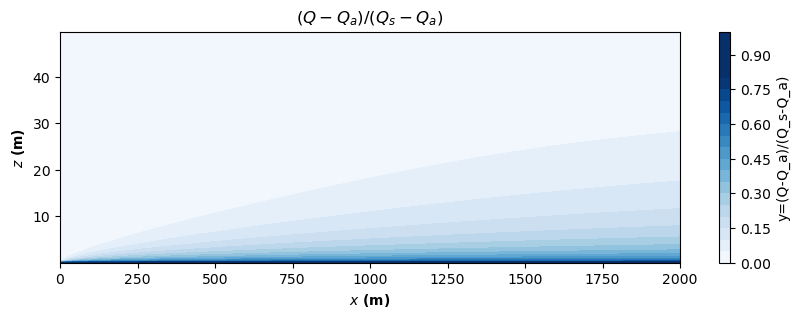

In [36]:

# Normalized concentration
Qd = (Q - Qa) / (Qs - Qa)

plt.figure(3, figsize = (10,3))
plt.clf()
plt.contourf(x, z, Qd.T.round(5), 20, vmax = 0.8, cmap='Blues')
plt.xlabel(r'$\it{x}$ (m)', fontweight='bold', fontsize=10)
plt.ylabel(r'$\it{z}$ (m)', fontweight='bold', fontsize=10)
plt.colorbar(label='y=(Q-Q_a)/(Q_s-Q_a)')
plt.title('$(Q-Q_a)/(Q_s-Q_a)$')


$$u \frac{\partial u}{\partial x} = - \frac{\partial}{\partial z} \overline{w'u'}$$

$$ \overline{w'u'} = - k_t \frac{\partial \overline u}{\partial z} $$

$$K_t = kz u^*$$

- Momentum adjustment is fast

$$u \frac{\partial T}{\partial x} = - \frac{\partial}{\partial z} \overline{w'T'}$$

$$ \overline{w'T'} = - T_t \frac{\partial \overline T}{\partial z} $$

$$K_t = k z u^*$$

$$ T_a - T_s = - \frac{ \overline{w'T'}}{k u_\star} \ln \bigg(\frac{z}{z_{oh}}\bigg) $$

$$  z_{oh} \approx 0.1 z_{om} $$

$$ q(z_{oh}) = e^{\star} (T_s)$$   
$z_{oh}$:  heat roughness heigh
$e^{\star} (T_s)$ : saturation vapor pressure


$$ - K_t \frac{\partial T}{\partial z} = - k z u_\star \frac{\partial T}{\partial z}  = const$$

$$ - k  u_\star d T = \frac{dz}{z} C $$


$$ d T = - \frac{dz}{z } \frac{C}{ k  u_\star }  $$

$$ K_t = \frac{- \overline{u'w'}}{\partial \overline u/ \partial z}= \  \text{flux of momentum} / \frac{\partial \overline u}{ \partial z} $$

$$ u_\star = (- \overline{u'w'})^{1/2} = \sqrt{\tau / \rho}$$

$$ \frac{\partial \overline u}{\partial z} = \frac{u_\star}{kz}$$

$$ \overline {u'w'} = - u_\star^2$$

$$ K_t = \frac{u_\star^2}{u_\star / kz} = u_\star ( kz )= \text{velocity}\times \text{length} $$ 

Upwind BCs

$$ T_a - T_s = - \frac{\overline{w'T'}}{k u_\star} ln (z / z_{oh}) $$


$ z_{om} = 0.1$ m, $ z_{oh} = 0.1 z_{om}$ m, $u_\star = 0.25 $ m/s

$$ 18 - 30 = - \frac{\overline{w'T'}}{k u_\star} \ln (200 /0.1^2) $$

$$  - \overline{w'T'} = (18 - 30 ) {k u_\star} / \ln (200 /0.1^2) $$

$\overline{w'T'}  $ -  Known from upwind boundwary condition and log law

Upwind profile prescribed



In [37]:
wT = (18 - 30 )*(0.4* 0.25 ) / np.log(200 /0.1**2) 

$$ \overline u = \frac{u_\star }{k} \big[ \ln (z/z_o) - \psi_m (z/z_o) \big]$$

$$ \overline u \frac{\partial \overline T }{\partial x} = - \frac{\partial}{\partial z } \overline {w'T'} $$

$$ \overline{w'T'} = - \frac{k z u_\star}{\phi_h (z/L)} \frac{\partial \overline T }{\partial z}  $$





$$ \overline u \frac{\partial \overline q }{\partial x} = - \frac{\partial}{\partial z } \overline {w'q'} $$

$$ \overline{w'q'} = - \frac{k z u_\star}{\phi_v (z/L)} \frac{\partial \overline q }{\partial z}  $$


Wall bounded flow : $\alpha T \sigma_w^2 = k z u_\star$



In [38]:
# can't be more complicated than if treating patches independently as if not cross talk